In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
 block_size = 3

 def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [38]:
 # MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embed))
W1 = torch.randn((n_embed * block_size, n_hidden)) * 0.01
b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

11897


In [39]:
max_steps = 200_000
batch_size = 32
i_loss = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  emb_cat = emb.view(emb.shape[0], -1) # concatenate the vectors
  h_pre_act = emb_cat @ W1 + b1
  h = torch.tanh(h_pre_act) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 10000 else 0.01 # learning rate annealing
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10_000 == 0:
    print("{} / {} : {}".format(i, max_steps, loss.item()))
  i_loss.append(loss.item())

  # break


0 / 200000 : 3.2954342365264893
10000 / 200000 : 2.175281524658203
20000 / 200000 : 2.5318760871887207
30000 / 200000 : 2.409273147583008
40000 / 200000 : 1.9229906797409058
50000 / 200000 : 2.019253969192505
60000 / 200000 : 2.04001784324646
70000 / 200000 : 2.338615655899048
80000 / 200000 : 2.153740167617798
90000 / 200000 : 2.6049628257751465
100000 / 200000 : 2.0579795837402344
110000 / 200000 : 2.4780349731445312
120000 / 200000 : 2.155325174331665
130000 / 200000 : 2.437579393386841
140000 / 200000 : 1.766351580619812
150000 / 200000 : 1.9618061780929565
160000 / 200000 : 1.8861325979232788
170000 / 200000 : 2.1793432235717773
180000 / 200000 : 2.0067620277404785
190000 / 200000 : 2.318237066268921


In [ ]:
# plt.hist(h.view(-1).tolist(), 50);
# plt.hist(h_pre_act.view(-1).tolist(), 50);
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest', aspect='auto')

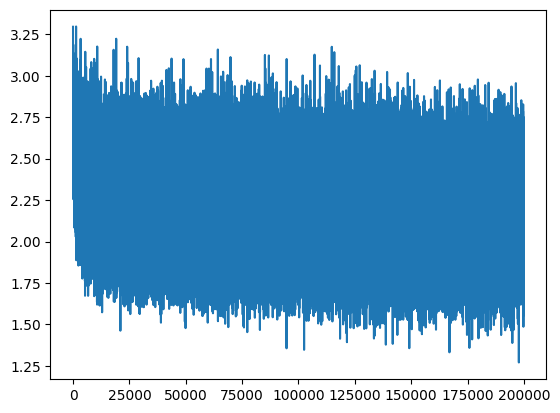

In [40]:
plt.plot(i_loss)

In [41]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embed)
  emb_cat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embed)
  h_pre_act = emb_cat @ W1 + b1
  h = torch.tanh(h_pre_act)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1389732360839844
val 2.160442352294922


In [18]:
for _ in range(20):
  out = []
  context  = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    emb_cat = emb.view(emb.shape[0], -1)
    h_pre_act = emb_cat @ W1 + b1
    h = torch.tanh(h_pre_act)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

brystte.
vinsleyone.
aliman.
comylen.
bryah.
divyn.
kexlelah.
jerettazelah.
ari.
marvontailer.
anicherin.
harekstelah.
lexghan.
kdwa.
elin.
shauan.
nikaide.
maiaraison.
melait.
elenet.


There are few things wrong with things here.

- Our initilisation is wrong. We start with high error which decreases way too quickly
 - When we start we can roughly estimate the loss.
 - For example in this case, we can expect that all characters have equal probability to occur in beginning. And this would give low loss
 - ```
 logits = torch.tensor([1.0, 5.0, 0.0, 10.0])
 probs = torch.softmax(logits, dim = 0)
 loss = -probs[2].log
 logits, probs, loss
 ```
 - We can't set Ws to be zero. You want them to be small but not zero. Things can go wrong
 - Doing this and our loss won't look like hockey stick. This is true for all NNs
 - **Fix** : We removed bias by multip;ying to zero. We multiplied Ws by 0.1 to reduce them.
- If we visualise `h` we see that we have too many 1s and -1s and that is because our `h` is tanh and it acts as squashing force.
 - Way to check: `plt.hist(h.view(-1).tolist(), 50);`
 - It is very active. Look at h_pre_act and you see it is very broad.
 - This is "sweating" situation for person who is training method.
 - Backward prop for tanh is `(1-t**2) * out.grad`. If outputs for t are very close to 1 or -1; we will get zero. No matter what out.grad is we are killing and basically stopping the propagation here.
 - Change input is not going to impact the output too much because if it is in flat region of tanh; there is no impact on the loss.
 - The gradient flowing through tanh can only ever decrease.
 - ```
 plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest', aspect='auto')
 ```
 - In above code you should see no column which is completely white. That represents dead neuron since you are just passing the out.grad and nothing is happening there.
 - So both of above cases, makes it that neuron never learns from here.
 - This is true for a lot of activation functions.
 - If it happens during learning, think of it as some permanent brain damage in network
 - This is happening because `h_pre_act` has very diverse values.
 - **Fix**: Same as above. We squash our inital weights and biases.

**Deeper the network is, more complex the network is the less forgiving initialisation is. The inconsistency keeps stacking up and may almost result in non-traning of network**


_But how do I come with this squashing magic numbers?_